In [1]:
%load_ext autoreload
%autoreload 2

In [42]:
import urllib
from datetime import datetime

import numpy as np
import pandas as pd

import hvplot.pandas

from neuclease.dvid import *
from neuclease.util import *
from neuclease.focused.ingest import fetch_focused_decisions, reexport_tasks_to_assignment

from neuclease import configure_default_logging
configure_default_logging()

### Proofreader Decisions

In [64]:
vnc_focused = ('https://hemibrain-dvid2.janelia.org', '36e0b', 'segmentation_focused')
decisions = fetch_focused_decisions(*vnc_focused, normalize_pairs='sv', update_with_instance=None, is_hemibrain=False)

# Use separate score columns depending on which process was used to generate the tasks
decisions['score'] = [info['score'] if 'score' in info else np.nan for info in tqdm_proxy(decisions['edge_info'])]
decisions['synth_score'] = [info['synth_score'] if 'synth_score' in info else np.nan for info in tqdm_proxy(decisions['edge_info'])]
print(f"Fetched {len(decisions)} decisions")

[2020-10-15 12:28:55,645] INFO Fetching keys from 'segmentation_focused'...
[2020-10-15 12:28:57,298] INFO Fetching keys from 'segmentation_focused' took 0:00:01.651845
[2020-10-15 12:28:57,299] INFO Fetching values from 'segmentation_focused'...


[2020-10-15 12:29:28,480] INFO Fetching values from 'segmentation_focused' took 0:00:31.180472



Fetched 221356 decisions


In [65]:
decisions['date_eastern'].astype(str).value_counts().rename('total tasks per day').sort_index(ascending=False).hvplot.barh()

:Bars   [index]   (total tasks per day)

### Check today's merge rate

4805 decisions so far today.


,count,pct
result,,
dontMerge,3156,65.7
merge,1623,33.8
dontKnow,26,0.5
skip (same body ID),0,0.0


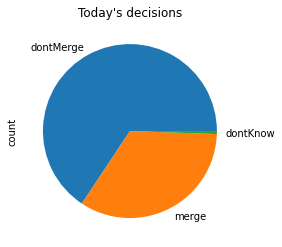

In [66]:
today = datetime.now().date()
today_decisions = decisions.query('date_eastern == @today')

print(f"{len(today_decisions)} decisions so far today.")

vc = today_decisions['result'].value_counts().rename('count').rename_axis('result').to_frame()
vc['pct'] = 100*(vc['count'] / vc['count'].sum())
vc['pct'] = np.round(vc['pct'], 1)
display(vc)
vc['count'].plot(kind='pie', title="Today's decisions");

### Per-user analysis

In [67]:
df = decisions

# Optional: Query for some decisions only
#df = decisions.query('not synth_score.isnull()')

user_merge_rates = df.groupby('user')['result'].agg(lambda s: s.value_counts()).reset_index()
user_merge_rates.columns = ['user', 'result', 'count']
user_merge_rates = user_merge_rates.merge( user_merge_rates.groupby('user')['count'].sum().rename('total_tasks').reset_index(), 'left', on='user' )
user_merge_rates = user_merge_rates.sort_values('total_tasks')
user_merge_rates['rate'] = user_merge_rates['count'] / user_merge_rates['total_tasks']
user_merge_rates = user_merge_rates.query('count > 0')

In [68]:
user_merge_rates.set_index(['user', 'result'])['count'].hvplot.barh(stacked=True, height=400, legend='bottom_right', title='decisions per user')

:Bars   [user,result]   (count)

In [69]:
# Same as above, but normalized by task count to make it easier to compare merge rates
user_merge_rates.set_index(['user', 'result'])['rate'].hvplot.barh(stacked=True, height=400, legend='bottom_left', title='decision rates per user')

:Bars   [user,result]   (rate)

### Show the merge rates for RAG-based tasks by (binned) score

In [91]:
# Change this bin width for more fine-grained visualization
bin_width = 0.05

# Select tasks with a 'score'
selections = decisions.query('not score.isnull()').copy()
selections['score_bin'] = bin_width*(selections['score'] // bin_width)

result_counts = (selections.query('result != "dontKnow"')[['score_bin', 'result']]
                     .groupby(['score_bin'])['result']
                     .agg([lambda x: x.value_counts().rename_axis('result').iloc[::-1],
                           lambda x: x.value_counts().rename_axis('result').iloc[::-1] / len(x)]))

result_counts.columns = ['count', 'rate']
result_counts['count'].hvplot.barh(stacked=True, legend='bottom_right', height=int(1000//(bin_width*100) + 100))

:Bars   [score_bin,result]   (count)

In [85]:
# Same as above, but normalized by task count to make it easier to compare merge rates
result_counts['rate'].hvplot.barh(stacked=True, legend='top_left', height=int(1000//(bin_width*100) + 100))

:Bars   [score_bin,result]   (rate)

### Show the merge rates for synth-based tasks by (binned) synth_score

In [86]:
# Change this bin width for more fine-grained visualization
bin_width = 5

selections = decisions.query('not synth_score.isnull()').copy()
selections['score_bin'] = bin_width*(selections['synth_score'] // bin_width)

result_counts = (selections.query('result != "dontKnow"')[['score_bin', 'result']]
                     .groupby(['score_bin'])['result']
                     .agg([lambda x: x.value_counts().rename_axis('result').iloc[::-1],
                           lambda x: x.value_counts().rename_axis('result').iloc[::-1] / len(x)]))

result_counts.columns = ['count', 'rate']
result_counts['count'].hvplot.barh(stacked=True, legend='top_right', height=1000//bin_width + 100)

:Bars   [score_bin,result]   (count)

In [87]:
# Same as above, but normalized by task count to make it easier to compare merge rates
result_counts['rate'].hvplot.barh(stacked=True, legend='top_left', height=1000//bin_width + 100)

:Bars   [score_bin,result]   (rate)

### Show a selection of decisions

In [70]:
cols = ['sv_a', 'sv_b', 'body_a', 'body_b', 'xa', 'ya', 'za', 'xb', 'yb', 'zb', 'score', 'synth_score', 'user']

# Example query
q = "date_eastern == @today and result == 'merge'"

selections = decisions.query(q).sort_values('synth_score')
selections[cols].head(10)

,sv_a,sv_b,body_a,body_b,xa,ya,za,xb,yb,zb,score,synth_score,user
216554,26813065737,30088862306,26813065737,30088862306,27548,19652,37472,27541,19616,37495,NaN,5.0,natalielynnsmith@gmail.com
218646,38008520055,38418866267,38008520055,38418866267,15698,37256,47736,15698,37264,47751,NaN,5.0,quatretribunal@gmail.com
218627,31807988689,31807992831,31807988689,31807992831,26195,30438,39716,26180,30436,39787,NaN,5.0,emanley8794@gmail.com
218601,5078230937,8753727872,5078230937,8753727872,24818,18613,12473,24817,18613,12473,NaN,5.0,dennis.aa.bailey@gmail.com
218591,15305329184,15308829923,15305329184,15308829923,25019,18254,19592,24902,18212,19500,NaN,5.0,dennis.aa.bailey@gmail.com
218576,22812304458,27312055233,22812304458,27312055233,29759,33176,34144,29704,33210,34263,NaN,5.0,emanley8794@gmail.com
218565,35978916729,36389226643,35978916729,36389226643,27558,40380,45372,27540,40383,45406,NaN,5.0,thomsonrymer@gmail.com
218524,22808926212,22808928269,22808926212,22808928269,31524,34627,28688,31500,34584,28722,NaN,5.0,cookmichaeledward@gmail.com
218508,32967635264,32967672398,32967635264,32967672398,17528,20576,41426,17558,20584,41456,NaN,5.0,emanley8794@gmail.com
218493,45359052808,45359058607,45359052808,45359058607,9828,32074,56632,9867,32090,56726,NaN,5.0,alfrancis1996@gmail.com


### Neuroglancer link for a particular task

In [73]:
DEFAULT_NG_SETTINGS = {
  "dimensions": {
    "x": [
      8e-9,
      "m"
    ],
    "y": [
      8e-9,
      "m"
    ],
    "z": [
      8e-9,
      "m"
    ]
  },
  "position": [
    22491.5,
    26671.6328125,
    31805.267578125
  ],
  "crossSectionScale": 1.1903340818685682,
  "projectionScale": 16050.60896397486,
  "layers": [
    {
      "type": "image",
      "source": {
        "url": "precomputed://gs://flyem-vnc-2-26-213dba213ef26e094c16c860ae7f4be0/v3_emdata_clahe_xy/jpeg",
        "subsources": {
          "default": True,
          "bounds": True
        },
        "enableDefaultSubsources": False
      },
      "tab": "source",
      "name": "v3_emdata_clahe_xy/jpeg"
    },
    {
      "type": "segmentation",
      "source": "precomputed://gs://vnc-v3-seg-3d2f1c08fd4720848061f77362dc6c17/rc4_wsexp",
      "tab": "source",
      "segments": [],
      "name": "supervoxels"
    },
    {
      "type": "segmentation",
      "source": "precomputed://gs://vnc-v3-seg-3d2f1c08fd4720848061f77362dc6c17/rc4_wsexp_rsg32_16_sep_8_sep1e6",
      "tab": "segments",
      "name": "agglo-8nm-except-1M-1M-merges",
      "visible": False
    }
  ],
  "showSlices": False,
  "prefetch": False,
  "selectedLayer": {
    "layer": "supervoxels",
    "visible": True
  },
  "layout": "4panel",
  "partialViewport": [
    0,
    0,
    1,
    1
  ]
}

In [74]:
def ng_link_for_row(tasks, index):
    ng_settings = copy.deepcopy(DEFAULT_NG_SETTINGS)

    sv_settings = [l for l in ng_settings["layers"] if l["name"] == "supervoxels" ][0]
    agglo_settings = [l for l in ng_settings["layers"] if l["name"].startswith("agglo")][0]

    sv_settings["segments"] = tasks.loc[index, ['sv_a', 'sv_b']].values.astype(str).tolist()
    agglo_settings["segments"] = tasks.loc[index, ['body_a', 'body_b']].values.astype(str).tolist()
    
    point_a = tasks.loc[index, ['xa', 'ya', 'za']].values
    point_b = tasks.loc[index, ['xb', 'yb', 'zb']].values
    midpoint = (point_a + point_b) / 2
    ng_settings["position"] = midpoint.tolist()
    
    url = "https://neuroglancer-demo.appspot.com/#!" + urllib.parse.quote(json.dumps(ng_settings))
    return url

In [75]:
ng_link_for_row(decisions, 208151)

'https://neuroglancer-demo.appspot.com/#!%7B%22dimensions%22%3A%20%7B%22x%22%3A%20%5B8e-09%2C%20%22m%22%5D%2C%20%22y%22%3A%20%5B8e-09%2C%20%22m%22%5D%2C%20%22z%22%3A%20%5B8e-09%2C%20%22m%22%5D%7D%2C%20%22position%22%3A%20%5B13033.0%2C%2033488.0%2C%2032871.0%5D%2C%20%22crossSectionScale%22%3A%201.1903340818685682%2C%20%22projectionScale%22%3A%2016050.60896397486%2C%20%22layers%22%3A%20%5B%7B%22type%22%3A%20%22image%22%2C%20%22source%22%3A%20%7B%22url%22%3A%20%22precomputed%3A//gs%3A//flyem-vnc-2-26-213dba213ef26e094c16c860ae7f4be0/v3_emdata_clahe_xy/jpeg%22%2C%20%22subsources%22%3A%20%7B%22default%22%3A%20true%2C%20%22bounds%22%3A%20true%7D%2C%20%22enableDefaultSubsources%22%3A%20false%7D%2C%20%22tab%22%3A%20%22source%22%2C%20%22name%22%3A%20%22v3_emdata_clahe_xy/jpeg%22%7D%2C%20%7B%22type%22%3A%20%22segmentation%22%2C%20%22source%22%3A%20%22precomputed%3A//gs%3A//vnc-v3-seg-3d2f1c08fd4720848061f77362dc6c17/rc4_wsexp%22%2C%20%22tab%22%3A%20%22source%22%2C%20%22segments%22%3A%20%5B%22252

### Re-export a selection of task results to a new assignment file

In [76]:
_ = reexport_tasks_to_assignment(decisions.tail(10), path='/tmp/exported-assignment.json')